In [4]:
import pandas as pd
final =pd.read_csv ("aid_sdr_eon_topic_final.csv", low_memory=False)

In [5]:
final

Report_Type Unique Identifier Date_Of_Occurrence    Aircraft_Type  \
0             AID   20191013023229A         2019-10-13    TAYLOR BC12-D   
1             AID   20191122023189A         2019-11-22     CIRRUS SR22T   
2             AID   20191125023199I         2019-11-25      MOONEY M20J   
3             AID   20191217023209A         2019-12-17        BEECH 35R   
4             AID   20191218023219I         2019-12-18  PIPER PA-28-151   
...           ...               ...                ...              ...   
73135         EON            570860         2019-03-19             C560   
73136         EON            570863         2019-03-29           P28A/G   
73137         EON            570944         2019-03-29             P28A   
73138         EON            570947         2019-03-29             CRJ7   
73139         EON            574105         2019-03-31     AIRBUS EC130   

      N_Number                                            Remarks  
0        96709  THE PILOT OBTAINED LOCAL AUTOMATED WEATHER REP...  
1        969JM  DEPARTED TRL FOR FLIGHT TO GLADEWATER. CLIMBED...  
2        3201L  ON NOVEMBER 25, 2019, AT APPROXIMATELY 1130 EA...  
3        3113V  THE PILOT/OWNER WAS INTENDING TO MAKE A SHORT ...  
4        6919J  A PORTION OF THE PROPELLER SEPARATED FROM AIRC...  
...        ...                                                ...  
73135   PAT092  EVIATION REPORTED BY ORF WHEN PAT092, C560, FA...  
73136    339MK  EVIATION REPORTED BY ZMP WHEN N339MK, P28A/G, ...  
73137   OXF165  EVIATION REPORTED BY ZAB WHEN OXF165, P28A, CL...  
73138  SKW3264  EVIATION REPORTED BY SCT WHEN SKW3264, CRJ7, T...  
73139   C-GTNV                          AIRBUS EC130, LATE REPORT  

[73140 rows x 6 columns]

In [6]:
grouped_multiple = final.groupby(['N_Number', 'Date_Of_Occurrence'])
for key,item in grouped_multiple:
    a_group = grouped_multiple.get_group(key)
print(a_group, "\n")

      Report_Type Unique Identifier Date_Of_Occurrence Aircraft_Type N_Number  \
69981         EON            564101         2019-03-05          C172     ZZ57   

                                                 Remarks  
69981  172, ACFT DEPARTED TO THE PRACTICE AREA AND RE...   



In [7]:
#import pandas as pd
#final =pd.read_csv ("aid_sdr_eon_topic_final.csv", low_memory=False)

In [8]:
final.dtypes

Report_Type           object
Unique Identifier     object
Date_Of_Occurrence    object
Aircraft_Type         object
N_Number              object
Remarks               object
dtype: object

In [9]:
final["Remarks"]=final["Remarks"].astype(str)

In [10]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [12]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
data = final.Remarks.values.tolist()

In [14]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['THE PILOT OBTAINED LOCAL AUTOMATED WEATHER REPORT FROM ICT (WICHITA DWIGHT '
 'D. EISENHOWER AIRPORT, WICHITA, KS) PRIOR TO TAKEOFF, INDICATING CLEAR '
 'SKIES, LIGHT/VARIABLE WINDS, AND TEMPERATURE 69F. ECK FIELD WINDSOCK '
 'INDICATED WINDS AT 7-10 MPH OUT OF THE SSE. THE PILOT TAXIED TO THE NORTH '
 'END OF RUNWAY WITH ONE PASSENGER, CONDUCTED A NORMAL RUN-UP AND THEN '
 'ADVANCED THE THROTTLE TO FULL POWER FOR THE TAKEOFF RUN. THE AIRCRAFT LIFTED '
 'OFF AT A NORMALLY EXPERIENCED DISTANCE. THE AIRCRAFT BEGAN TO DRIFT TO THE '
 'LEFT AND THE PILOT CORRECTED TO MAINTAIN RUNWAY ALIGNMENT. AT THIS POINT, '
 'THE PILOT FELT THE AIRCRAFT BECOME ?MUSHY? AND NOTICED HIS AIRSPEED WAS '
 'DECREASING. THE PILOT THEN LOWERED THE AIRCRAFT?S NOSE TO REGAIN AIRSPEED '
 'AND CONTROLLABILITY, BUT THE MUSHINESS CONTINUED EVEN AFTER LOWERING THE '
 'NOSE EVEN FURTHER. THE PILOT KEPT THE WINGS LEVEL UNTIL THE AIRCRAFT '
 'CONTACTED THE GROUND IN THE SOFT FIELD DIRECTLY OFF THE END OF THE RUNWAY, '
 

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'pilot', 'obtained', 'local', 'automated', 'weather', 'report', 'from', 'ict', 'wichita', 'dwight', 'eisenhower', 'airport', 'wichita', 'ks', 'prior', 'to', 'takeoff', 'indicating', 'clear', 'skies', 'light', 'variable', 'winds', 'and', 'temperature', 'eck', 'field', 'windsock', 'indicated', 'winds', 'at', 'mph', 'out', 'of', 'the', 'sse', 'the', 'pilot', 'taxied', 'to', 'the', 'north', 'end', 'of', 'runway', 'with', 'one', 'passenger', 'conducted', 'normal', 'run', 'up', 'and', 'then', 'advanced', 'the', 'throttle', 'to', 'full', 'power', 'for', 'the', 'takeoff', 'run', 'the', 'aircraft', 'lifted', 'off', 'at', 'normally', 'experienced', 'distance', 'the', 'aircraft', 'began', 'to', 'drift', 'to', 'the', 'left', 'and', 'the', 'pilot', 'corrected', 'to', 'maintain', 'runway', 'alignment', 'at', 'this', 'point', 'the', 'pilot', 'felt', 'the', 'aircraft', 'become', 'mushy', 'and', 'noticed', 'his', 'airspeed', 'was', 'decreasing', 'the', 'pilot', 'then', 'lowered', 'the', 'aircr

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'pilot', 'obtained', 'local', 'automated_weather', 'report', 'from', 'ict', 'wichita', 'dwight', 'eisenhower', 'airport', 'wichita', 'ks', 'prior', 'to', 'takeoff', 'indicating', 'clear_skies', 'light', 'variable', 'winds', 'and', 'temperature', 'eck', 'field', 'windsock', 'indicated', 'winds', 'at', 'mph', 'out', 'of', 'the', 'sse', 'the', 'pilot', 'taxied', 'to', 'the', 'north', 'end', 'of', 'runway', 'with', 'one', 'passenger', 'conducted', 'normal', 'run', 'up', 'and', 'then', 'advanced', 'the', 'throttle', 'to', 'full', 'power', 'for', 'the', 'takeoff', 'run', 'the', 'aircraft', 'lifted', 'off', 'at', 'normally', 'experienced', 'distance', 'the', 'aircraft', 'began', 'to', 'drift', 'to', 'the', 'left', 'and', 'the', 'pilot', 'corrected', 'to', 'maintain', 'runway', 'alignment', 'at', 'this', 'point', 'the', 'pilot', 'felt', 'the', 'aircraft', 'become', 'mushy', 'and', 'noticed', 'his', 'airspeed', 'was', 'decreasing', 'the', 'pilot', 'then', 'lowered', 'the', 'aircraft', '

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
spacy.load("en_core_web_sm")
import en_core_web_sm

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['pilot', 'obtain', 'local', 'report', 'takeoff', 'indicate', 'clear_skie', 'light', 'variable', 'wind', 'temperature', 'eck', 'field', 'windsock', 'indicate', 'wind', 'mph', 'sse', 'pilot', 'taxi', 'end', 'runway', 'passenger', 'conduct', 'normal', 'run', 'advanced', 'full', 'power', 'takeoff', 'aircraft', 'lift', 'normally', 'experience', 'distance', 'aircraft', 'begin', 'leave', 'pilot', 'correct', 'maintain', 'runway', 'alignment', 'point', 'pilot', 'feel', 'aircraft', 'become', 'noticed', 'airspeed', 'decrease', 'pilot', 'lower', 'aircraft', 'nose', 'regain', 'airspee', 'controllability', 'mushiness', 'continue', 'even', 'lower', 'nose', 'even', 'pilot', 'keep', 'wing', 'level', 'aircraft', 'contact', 'grind', 'soft', 'field', 'directly', 'end', 'runway', 'come', 'sudden', 'stop', 'pilot', 'notice', 'windsock', 'switch', 'direction', 'indicate', 'mph', 'wind', 'nne', 'incident', 'aircraft', 'suffer', 'substantial', 'damage', 'pilot', 'minor', 'injury', 'passenger', 'uninjured', '

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 7), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 2), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 3), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 9), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 3), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 3), (73, 2), (74, 1)]]


In [21]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advanced', 1),
  ('aircraft', 7),
  ('airspee', 1),
  ('airspeed', 1),
  ('alignment', 1),
  ('become', 1),
  ('begin', 1),
  ('capability', 1),
  ('clear_skie', 1),
  ('come', 1),
  ('conduct', 1),
  ('contact', 1),
  ('continue', 1),
  ('controllability', 1),
  ('correct', 1),
  ('counsel', 1),
  ('damage', 1),
  ('decrease', 1),
  ('direction', 1),
  ('directly', 1),
  ('distance', 1),
  ('eck', 1),
  ('end', 2),
  ('even', 2),
  ('experience', 1),
  ('feel', 1),
  ('field', 2),
  ('full', 1),
  ('grind', 1),
  ('incident', 1),
  ('indicate', 3),
  ('injury', 1),
  ('keep', 1),
  ('leave', 1),
  ('level', 1),
  ('lift', 1),
  ('light', 1),
  ('limit', 1),
  ('local', 1),
  ('lower', 2),
  ('maintain', 1),
  ('minor', 1),
  ('mph', 2),
  ('mushiness', 1),
  ('nne', 1),
  ('normal', 1),
  ('normally', 1),
  ('nose', 2),
  ('notice', 1),
  ('noticed', 1),
  ('obtain', 1),
  ('operate', 1),
  ('passenger', 2),
  ('pilot', 9),
  ('point', 1),
  ('power', 1),
  ('regain', 1),
  ('repo

In [22]:
np.random.seed(1234)
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
# Print the Keyword in the 8 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.083*"attendant" + 0.065*"oxygen" + 0.049*"ill" + 0.045*"burn" + '
  '0.029*"flat" + 0.024*"around" + 0.021*"assist" + 0.020*"lower" + '
  '0.017*"bag" + 0.015*"ea"'),
 (1,
  '0.139*"ramp" + 0.132*"damage" + 0.046*"side" + 0.039*"instruction" + '
  '0.031*"strike" + 0.029*"area" + 0.026*"wing" + 0.025*"vertical" + '
  '0.024*"low" + 0.020*"cross"'),
 (2,
  '0.366*"incident" + 0.094*"depart" + 0.094*"gate" + 0.081*"acft" + '
  '0.057*"enter" + 0.025*"parking" + 0.017*"reporting" + 0.015*"crew" + '
  '0.014*"pressurization" + 0.012*"instruct"'),
 (3,
  '0.101*"head" + 0.100*"descend" + 0.067*"drone" + 0.034*"pd_notifie" + '
  '0.027*"sea" + 0.024*"level" + 0.019*"non" + 0.019*"fl" + 0.018*"late" + '
  '0.017*"location"'),
 (4,
  '0.204*"medical" + 0.176*"passenger" + 0.114*"emergency" + '
  '0.044*"assistance" + 0.041*"bind" + 0.035*"female" + 0.027*"door" + '
  '0.026*"year_old" + 0.023*"male" + 0.021*"pressure"'),
 (5,
  '0.087*"publish" + 0.049*"enforcement" + 0.048*"local_la

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.046221347099081

Coherence Score:  0.4724823662425709


In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.272161  0.223127       1        1  34.989450
6     -0.247920 -0.187253       2        1  27.487817
1      0.006279  0.088661       3        1  21.408937
4     -0.111141 -0.296895       4        1   4.939539
2     -0.027723  0.230346       5        1   4.337268
3      0.202553 -0.008216       6        1   3.489244
5      0.222916 -0.024753       7        1   1.977540
0      0.227197 -0.025017       8        1   1.370205, topic_info=            Term          Freq         Total Category  logprob  loglift
29      incident  17425.000000  17425.000000  Default  30.0000  30.0000
437    emergency  35582.000000  35582.000000  Default  29.0000  29.0000
969         ramp  32669.000000  32669.000000  Default  28.0000  28.0000
16        damage  30958.000000  30958.000000  Default  27.0000  27.0000
57        report  42558.000000  42558.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1059    consider     58.537131     60.753013   Topic8  -5.5499   4.2531
815       middle     57.382719     59.595337   Topic8  -5.5699   4.2524
13956    breathe    168.703737    183.061418   Topic8  -4.4915   4.2085
1433   transport    195.214392    261.864267   Topic8  -4.3455   3.9965
193       injure     87.898915    110.542559   Topic8  -5.1434   4.0610

[304 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
908        3  0.004493  abnormal
908        4  0.988531  abnormal
908        7  0.004493  abnormal
284        2  0.998463     abort
284        3  0.000624     abort
...      ...       ...       ...
821        3  0.998693     wrong
821        7  0.000828     wrong
18449      3  0.000713  year_old
18449      4  0.998458  year_old
18449      7  0.000713  year_old

[786 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 2, 5, 3, 4, 6, 1])

In [26]:



import os
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = 'D:\mallet-2.0.8'
mallet_path = r'D:\mallet-2.0.8\bin\mallet'

#os.environ.update({'MALLET_HOME':r'E:\Studies\SEM 4 SPRING 2021\Dhruvith Python\mallet-2.0.8\'})
#mallet_path = r'E:\Studies\SEM 4 SPRING 2021\Python\mallet-2.0.8'



In [27]:
np.random.seed(1234)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [28]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('aircraft', 0.05252088215852413),
   ('pilot', 0.04452256474971456),
   ('gear', 0.04059852172345412),
   ('landing', 0.028387717084309837),
   ('runway', 0.017697253770807043),
   ('leave', 0.015299561324439636),
   ('flight', 0.01435009915269515),
   ('time', 0.012373054503936061),
   ('nose', 0.012018508503094766),
   ('approximately', 0.011814193858542155)]),
 (1,
  [('repair', 0.13913083166614687),
   ('wing', 0.057029187807605415),
   ('low', 0.04487330650621106),
   ('side', 0.041358902775770395),
   ('skin', 0.03542549388022121),
   ('upper', 0.02894438570200595),
   ('crack', 0.023573889958085792),
   ('find', 0.023315254185715697),
   ('fitting', 0.02302619067541971),
   ('fuselage', 0.01945853840360873)]),
 (2,
  [('emergency', 0.10270697326292154),
   ('light', 0.10177554160256144),
   ('pack', 0.03735706266372822),
   ('exit', 0.03542766851012516),
   ('replace', 0.033789346750384634),
   ('battery', 0.03195974884610587),
   ('inop', 0.02821738949644476),
   ('fin

#### My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

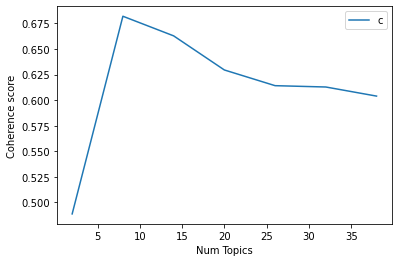

In [31]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Here we can notice that total number of topics being 8 has the highest coherence value.Hence we have choosen 8 for building our model

In [32]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4887
Num Topics = 8  has Coherence Value of 0.6821
Num Topics = 14  has Coherence Value of 0.6629
Num Topics = 20  has Coherence Value of 0.6295
Num Topics = 26  has Coherence Value of 0.6142
Num Topics = 32  has Coherence Value of 0.6129
Num Topics = 38  has Coherence Value of 0.604


In [33]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.084*"crack" + 0.062*"low" + 0.059*"wing" + 0.043*"side" + 0.035*"instal" '
  '+ 0.030*"upper" + 0.024*"repair" + 0.024*"fitting" + 0.022*"forward" + '
  '0.019*"surface" + 0.019*"hand" + 0.018*"hole" + 0.018*"left" + 0.018*"find" '
  '+ 0.017*"ea"'),
 (1,
  '0.091*"replace" + 0.072*"panel" + 0.069*"floor" + 0.051*"remove" + '
  '0.048*"area" + 0.048*"corrode" + 0.048*"support" + 0.028*"accomplish" + '
  '0.028*"aft" + 0.025*"corrosion" + 0.023*"cabin" + 0.018*"angle" + '
  '0.017*"web" + 0.017*"cargo" + 0.015*"structure"'),
 (2,
  '0.062*"engine" + 0.035*"find" + 0.031*"pressure" + 0.030*"note" + '
  '0.029*"fuel" + 0.018*"apu" + 0.017*"run" + 0.017*"leak" + 0.017*"pack" + '
  '0.017*"remove" + 0.016*"oil" + 0.015*"start" + 0.014*"perform" + '
  '0.013*"valve" + 0.013*"smoke"'),
 (3,
  '0.098*"aircraft" + 0.082*"report" + 0.062*"land" + 0.042*"due" + '
  '0.035*"incident" + 0.030*"flight" + 0.030*"passenger" + 0.030*"return" + '
  '0.024*"issue" + 0.024*"taxi" + 0.022*"declar

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             6.0              0.5220   
1            1             6.0              0.3652   
2            2             6.0              0.3892   
3            3             6.0              0.3920   
4            4             6.0              0.3623   
5            5             6.0              0.4531   
6            6             6.0              0.3712   
7            7             6.0              0.4621   
8            8             6.0              0.3622   
9            9             6.0              0.3489   

                                            Keywords  \
0  aircraft, pilot, gear, landing, runway, flight...   
1  aircraft, pilot, gear, landing, runway, flight...   
2  aircraft, pilot, gear, landing, runway, flight...   
3  aircraft, pilot, gear, landing, runway, flight...   
4  aircraft, pilot, gear, landing, runway, flight...   
5  aircraft, pilot, gear, landing, runway, flight...   
6  aircraft, pilot, gear, landing, runway, flight...   
7  aircraft, pilot, gear, landing, runway, flight...   
8  aircraft, pilot, gear, landing, runway, flight...   
9  aircraft, pilot, gear, landing, runway, flight...   

                                                Text  
0  THE PILOT OBTAINED LOCAL AUTOMATED WEATHER REP...  
1  DEPARTED TRL FOR FLIGHT TO GLADEWATER. CLIMBED...  
2  ON NOVEMBER 25, 2019, AT APPROXIMATELY 1130 EA...  
3  THE PILOT/OWNER WAS INTENDING TO MAKE A SHORT ...  
4  A PORTION OF THE PROPELLER SEPARATED FROM AIRC...  
5  ON FRIDAY, NOVEMBER 1, 2019, A ZENITH CH701, R...  
6  ON NOVEMBER 1, 2019, AT 1350 CDT, A CESSNA 210...  
7  ON OCTOBER 31 2019 APPROXIMATELY 11:15 EST LOC...  
8  ON OCTOBER 14/2019, AT 1405 EDT (1805Z), AN AI...  
9  ON OCTOBER 17, 2019, AT 1404 MDT, A 1996 WEATH...

In [35]:
# Show
df_dominant_topic.head(5000)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0               0             6.0              0.5220   
1               1             6.0              0.3652   
2               2             6.0              0.3892   
3               3             6.0              0.3920   
4               4             6.0              0.3623   
...           ...             ...                 ...   
4995         4995             4.0              0.2013   
4996         4996             6.0              0.1901   
4997         4997             7.0              0.2033   
4998         4998             7.0              0.1935   
4999         4999             2.0              0.1940   

                                               Keywords  \
0     aircraft, pilot, gear, landing, runway, flight...   
1     aircraft, pilot, gear, landing, runway, flight...   
2     aircraft, pilot, gear, landing, runway, flight...   
3     aircraft, pilot, gear, landing, runway, flight...   
4     aircraft, pilot, gear, landing, runway, flight...   
...                                                 ...   
4995  repair, find, corrosion, seat, srm, skin, main...   
4996  aircraft, pilot, gear, landing, runway, flight...   
4997  light, emergency, door, replace, maintenance, ...   
4998  light, emergency, door, replace, maintenance, ...   
4999  engine, find, pressure, note, fuel, apu, run, ...   

                                                   Text  
0     THE PILOT OBTAINED LOCAL AUTOMATED WEATHER REP...  
1     DEPARTED TRL FOR FLIGHT TO GLADEWATER. CLIMBED...  
2     ON NOVEMBER 25, 2019, AT APPROXIMATELY 1130 EA...  
3     THE PILOT/OWNER WAS INTENDING TO MAKE A SHORT ...  
4     A PORTION OF THE PROPELLER SEPARATED FROM AIRC...  
...                                                 ...  
4995  CORROSION FOUND ON THE SHEAR TIE, FRAME 55, ST...  
4996  THE PILOT REPORTED THAT ON FINAL WITH FLAPS 20...  
4997  FLOOR EMERGENCY LIGHT LENS, LEFT WALL, WAS FOU...  
4998  FLOOR EMERGENCY LIGHT ASSEMBLY WAS FOUND DAMAG...  
4999  FLIGHT CREW REPORTED A STRONG ODOR DURING CLIM...  

[5000 rows x 5 columns]

In [36]:
df_dominant_topic.to_csv (r'E:\Studies\SEM 4 SPRING 2021\Dhruvith Python\ last.csv', index = False, header=True)

print (df_dominant_topic)

       Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0                0             6.0              0.5220   
1                1             6.0              0.3652   
2                2             6.0              0.3892   
3                3             6.0              0.3920   
4                4             6.0              0.3623   
...            ...             ...                 ...   
73135        73135             3.0              0.2227   
73136        73136             3.0              0.1954   
73137        73137             3.0              0.1974   
73138        73138             3.0              0.2083   
73139        73139             3.0              0.1544   

                                                Keywords  \
0      aircraft, pilot, gear, landing, runway, flight...   
1      aircraft, pilot, gear, landing, runway, flight...   
2      aircraft, pilot, gear, landing, runway, flight...   
3      aircraft, pilot, gear, landing, runway, flight...   
4  

In [37]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(50)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.4878   
1        1.0              0.4592   
2        2.0              0.5391   
3        3.0              0.3791   
4        4.0              0.6113   
5        5.0              0.5023   
6        6.0              0.7124   
7        7.0              0.3984   

                                            Keywords  \
0  crack, low, wing, side, instal, upper, repair,...   
1  replace, panel, floor, remove, area, corrode, ...   
2  engine, find, pressure, note, fuel, apu, run, ...   
3  aircraft, report, land, due, incident, flight,...   
4  repair, find, corrosion, seat, srm, skin, main...   
5  check, good, perform, test, ground, fault, op,...   
6  aircraft, pilot, gear, landing, runway, flight...   
7  light, emergency, door, replace, maintenance, ...   

                                                Text  
0  LEFT HAND WING - OUTBOARD FLAP INBOARD FORWARD...  
1  DURING BASIC CHECK AT EAMS, CORROSION DAMAGE W...  
2  ON AUGUST 13, 2019, A BELL 206B JETRANGER WAS ...  
3  , CRJ7, PSP-SLC, OLDER FEMALE ON BOARD VOMITIN...  
4  MDCC 242GJ FLOOR PANEL BROKEN FABRICATED 242GJ...  
5  #1 ENGINE VIB INDICATION BLANKING INT. GROUNDE...  
6  ON SEPTEMBER 20, 2019 AT APPROXIMATELY 16:30 U...  
7  EMERGENCY ASILE LIGHTS AT ROWS 6 TO 11 INOP. E...

In [38]:
##############################

In [39]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.4878   
1        1.0              0.4592   
2        2.0              0.5391   
3        3.0              0.3791   
4        4.0              0.6113   
5        5.0              0.5023   
6        6.0              0.7124   
7        7.0              0.3984   

                                                                             Keywords  \
0            crack, low, wing, side, instal, upper, repair, fitting, forward, surface   
1   replace, panel, floor, remove, area, corrode, support, accomplish, aft, corrosion   
2                    engine, find, pressure, note, fuel, apu, run, leak, pack, remove   
3       aircraft, report, land, due, incident, flight, passenger, return, issue, taxi   
4                repair, find, corrosion, seat, srm, skin, main, track, damage, frame   
5                 check, good, perform, test, ground, fault, op, normal, fail, system   
6  aircraft, pilot, gear, landing, runway, flight, leave, damage, nose, approximately   
7  light, emergency, door, replace, maintenance, exit, battery, service, inop, ground   

                                                                                   Representative Text  
0  LEFT HAND WING - OUTBOARD FLAP INBOARD FORWARD HINGE ( WING SIDE) LOWER MOUNT OUTBOARD HOLE SURF...  
1  DURING BASIC CHECK AT EAMS, CORROSION DAMAGE WAS DISCOVERED ON SHEAR CLIPS, INTERCOSTALS AND ANG...  
2  ON AUGUST 13, 2019, A BELL 206B JETRANGER WAS RETURNING TO BASE IN OLYMPIA, WASHINGTON WHEN THE ...  
3  , CRJ7, PSP-SLC, OLDER FEMALE ON BOARD VOMITING UNCONTROLLABLY. NURSE ON BOARD ATTENDING. DIVERT...  
4  MDCC 242GJ FLOOR PANEL BROKEN FABRICATED 242GJ FLOOR PANEL ON VTMAE TRAVELER # T19/1411075 PER D...  
5  #1 ENGINE VIB INDICATION BLANKING INT. GROUNDED - YES. PERFORMED AVM SIGNAL CONDITIONER BITE PER...  
6  ON SEPTEMBER 20, 2019 AT APPROXIMATELY 16:30 UTC. N895SF, A CESSNA 208B, WHILE ON SHORT FINAL TO...  
7  EMERGENCY ASILE LIGHTS AT ROWS 6 TO 11 INOP. EMERGENCY ASILE LIGHT AT ROW 4 AND R1 DOOR EMERGENC...

###  When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

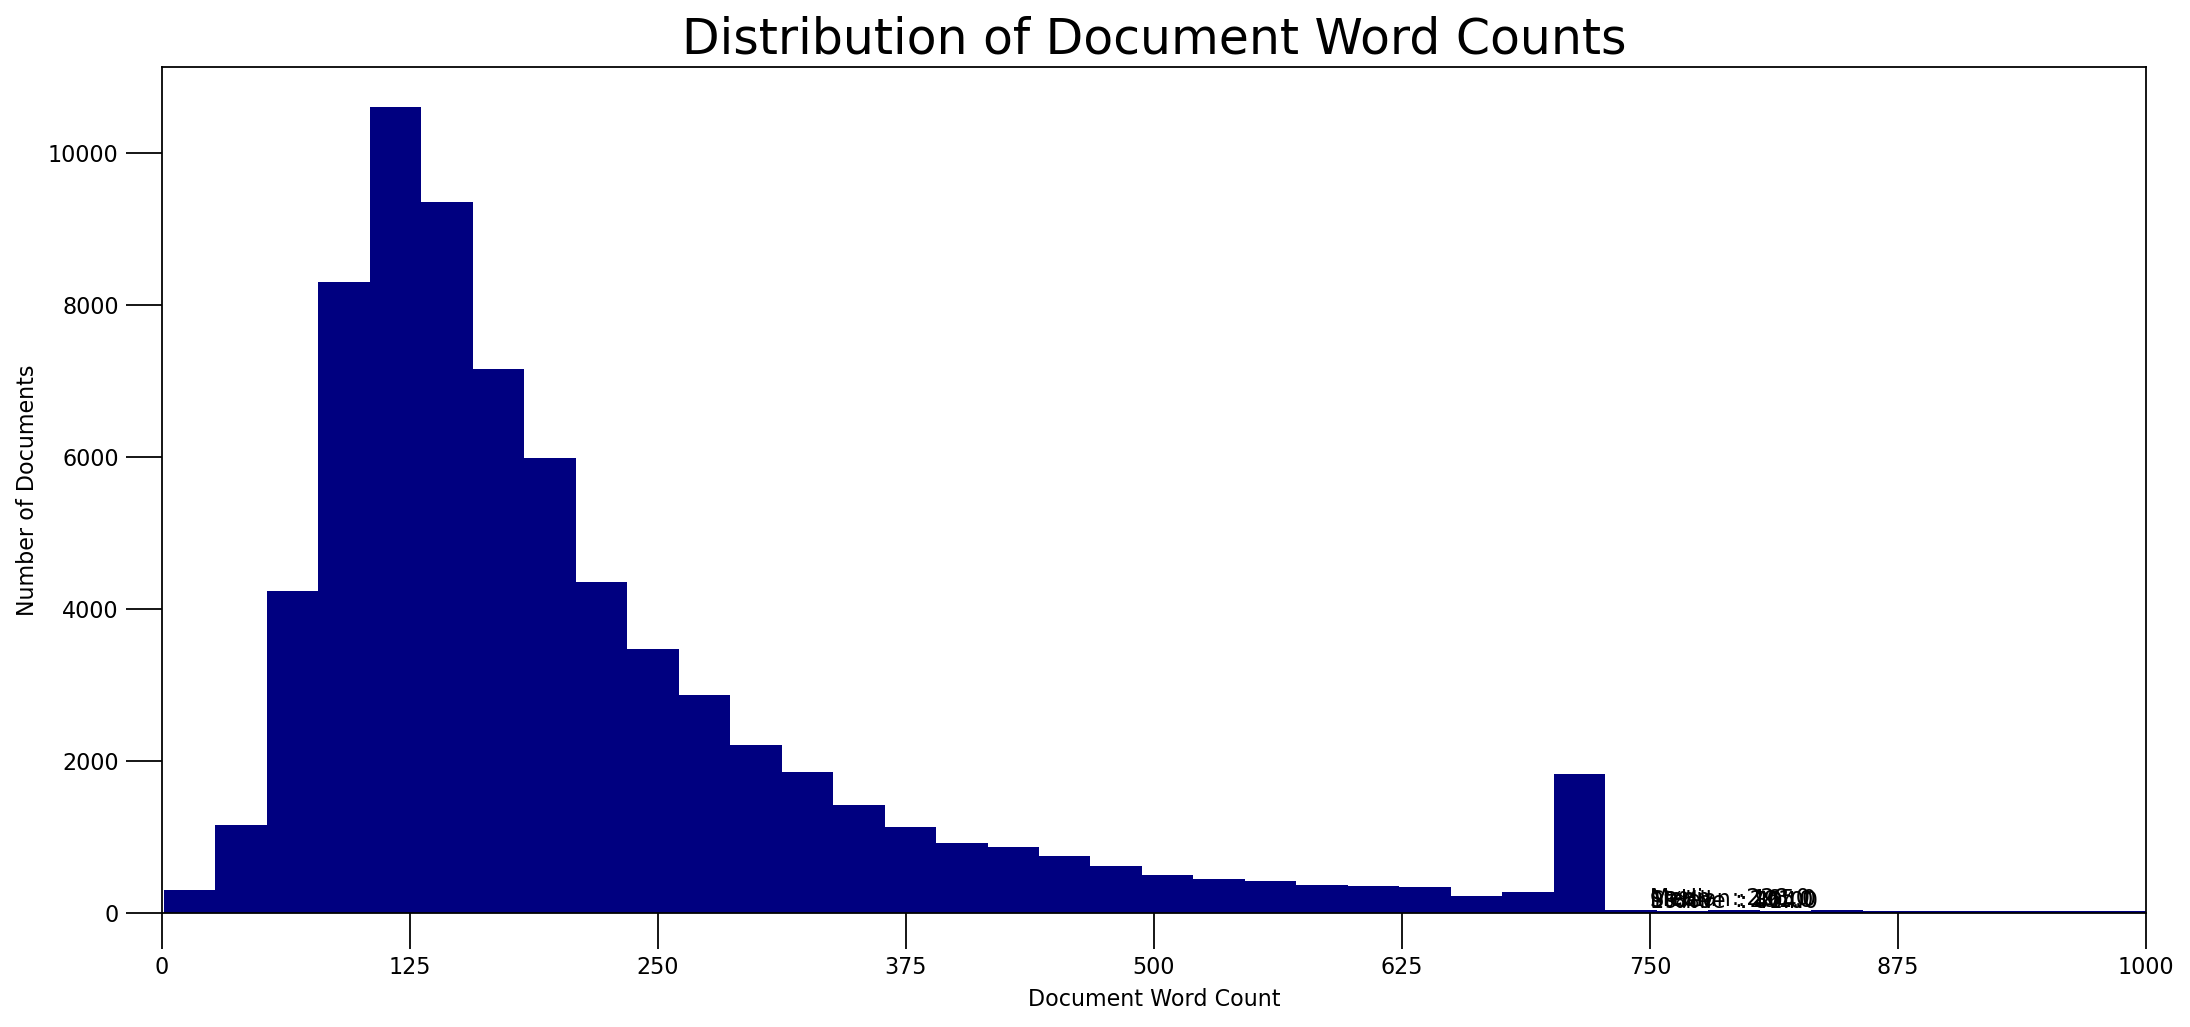

In [40]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

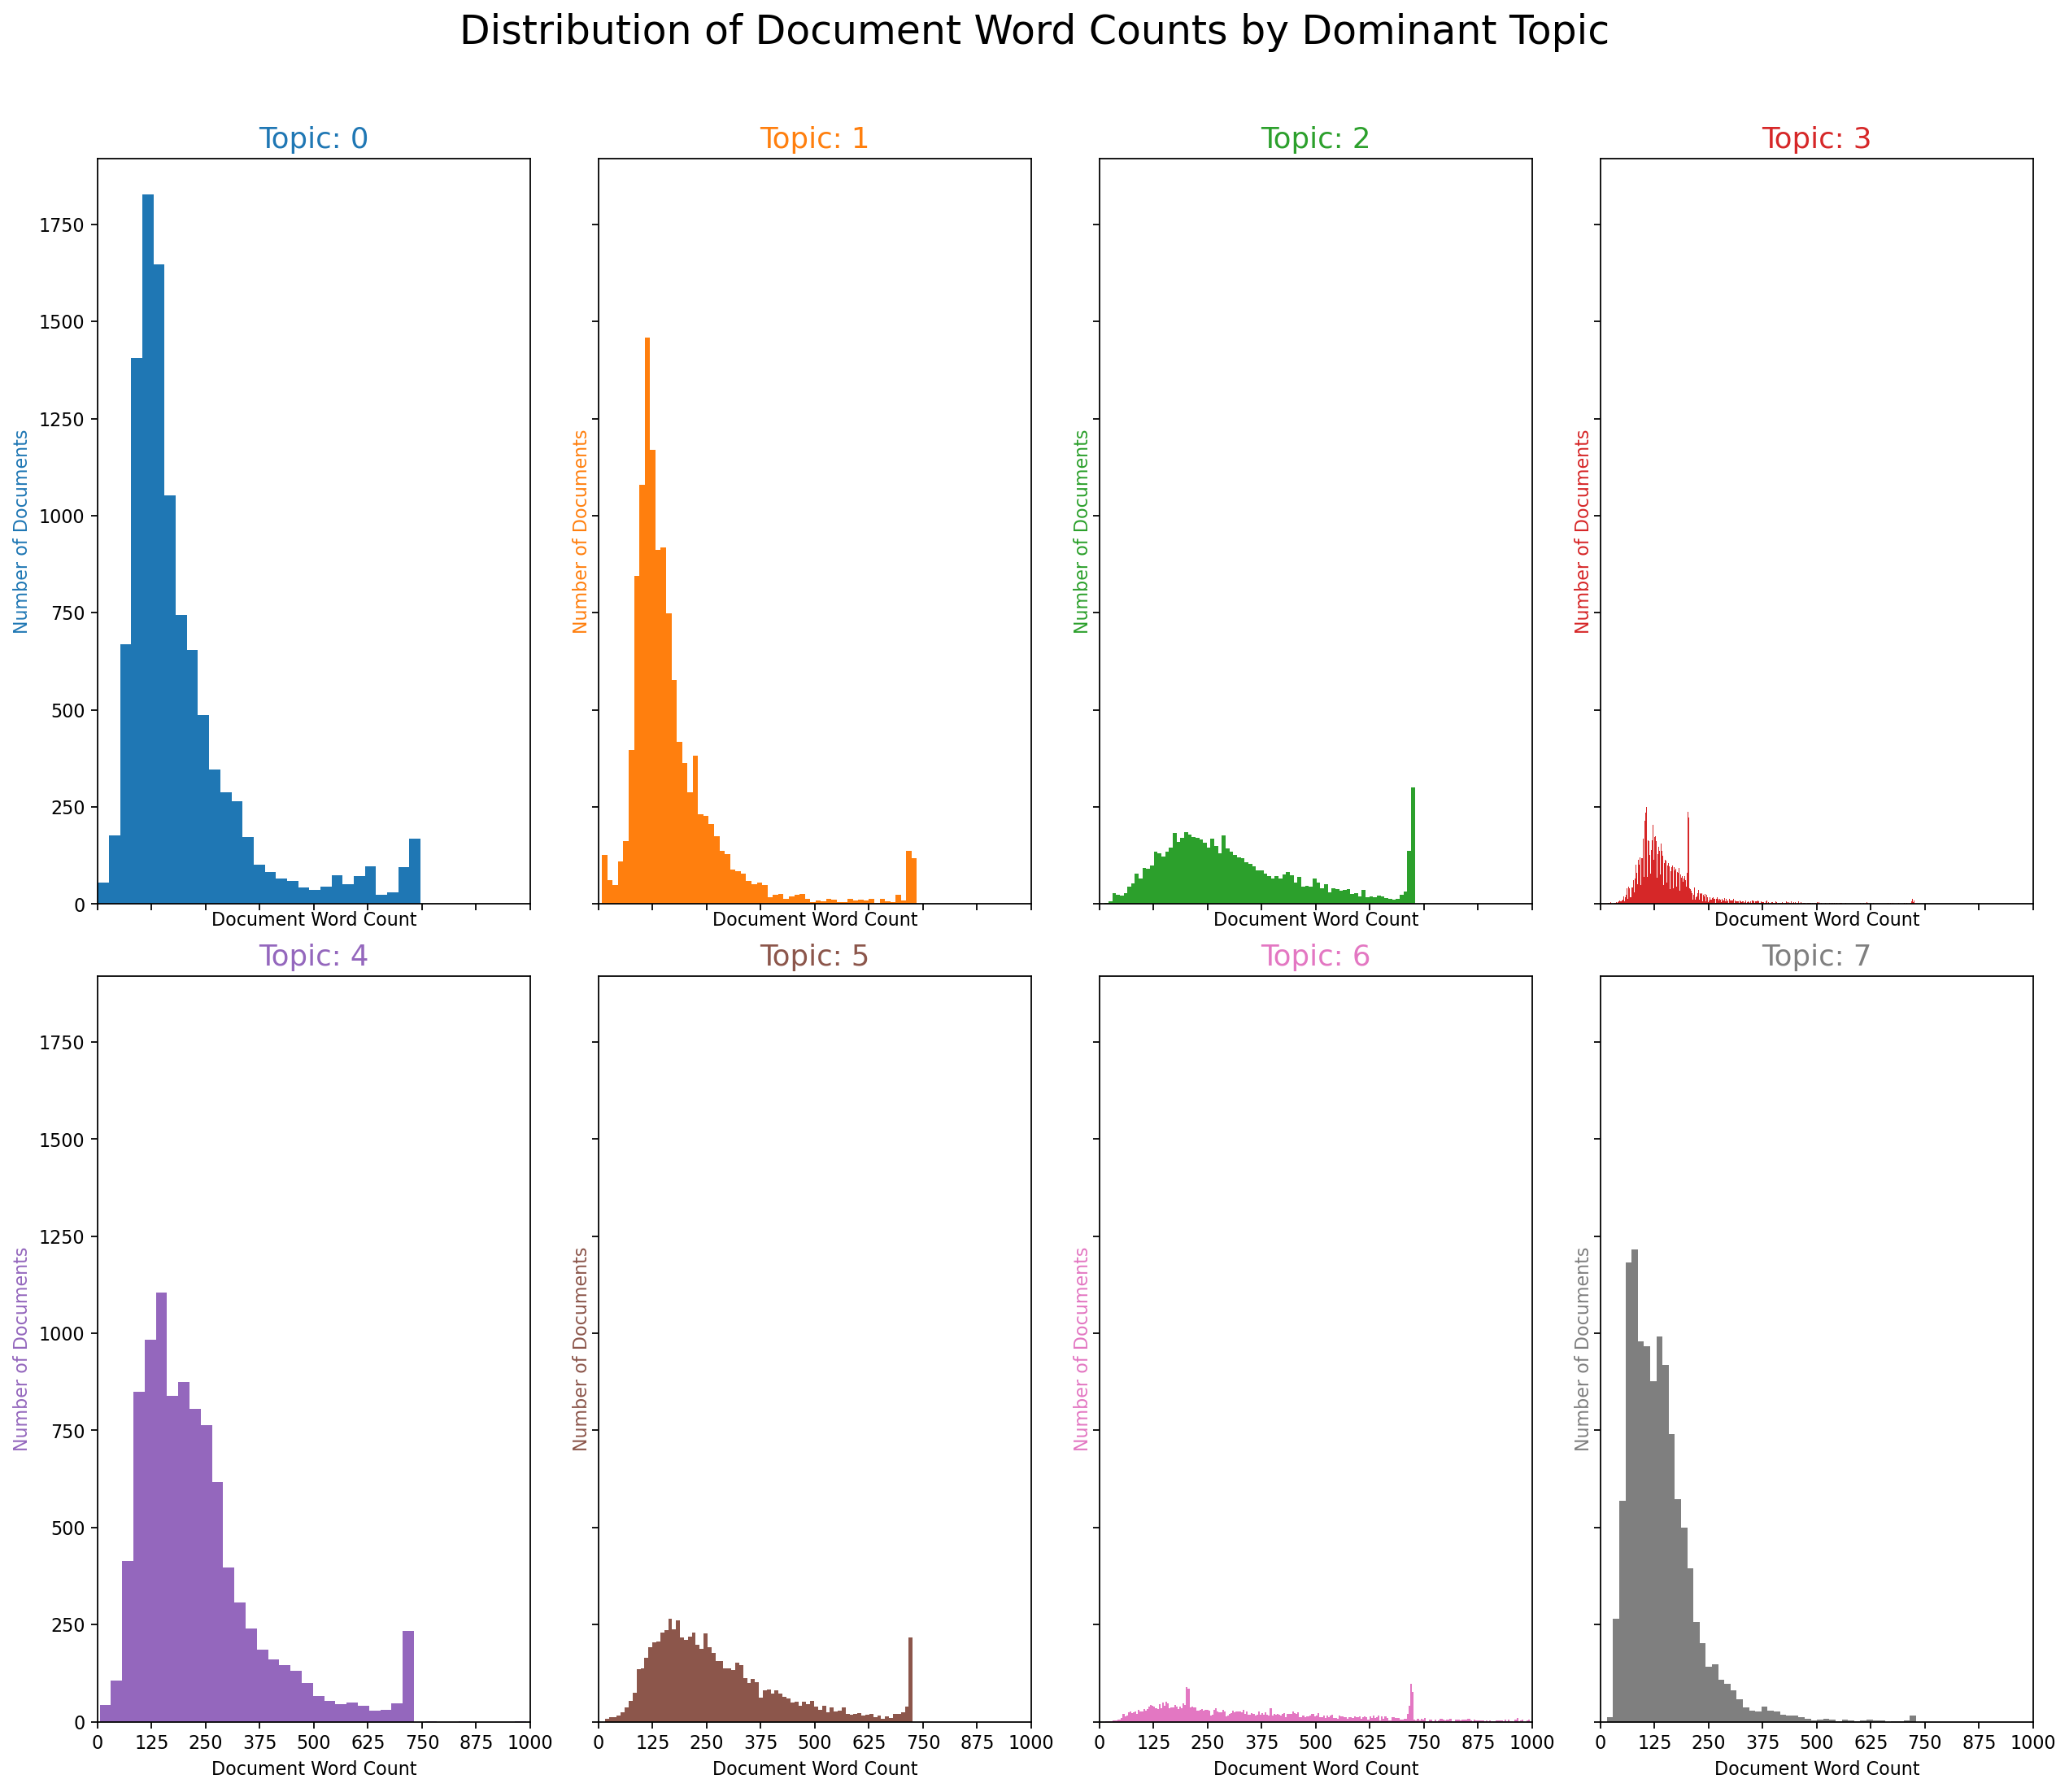

In [41]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,4,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    #ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    #sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

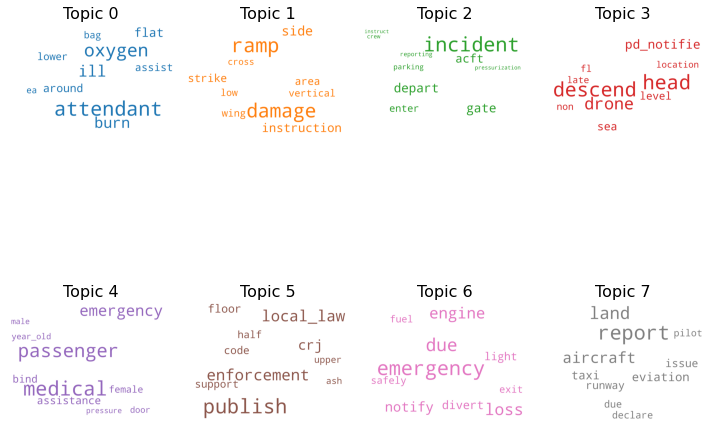

In [42]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.Let’s plot the word counts and the weights of each keyword in the same chart.You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

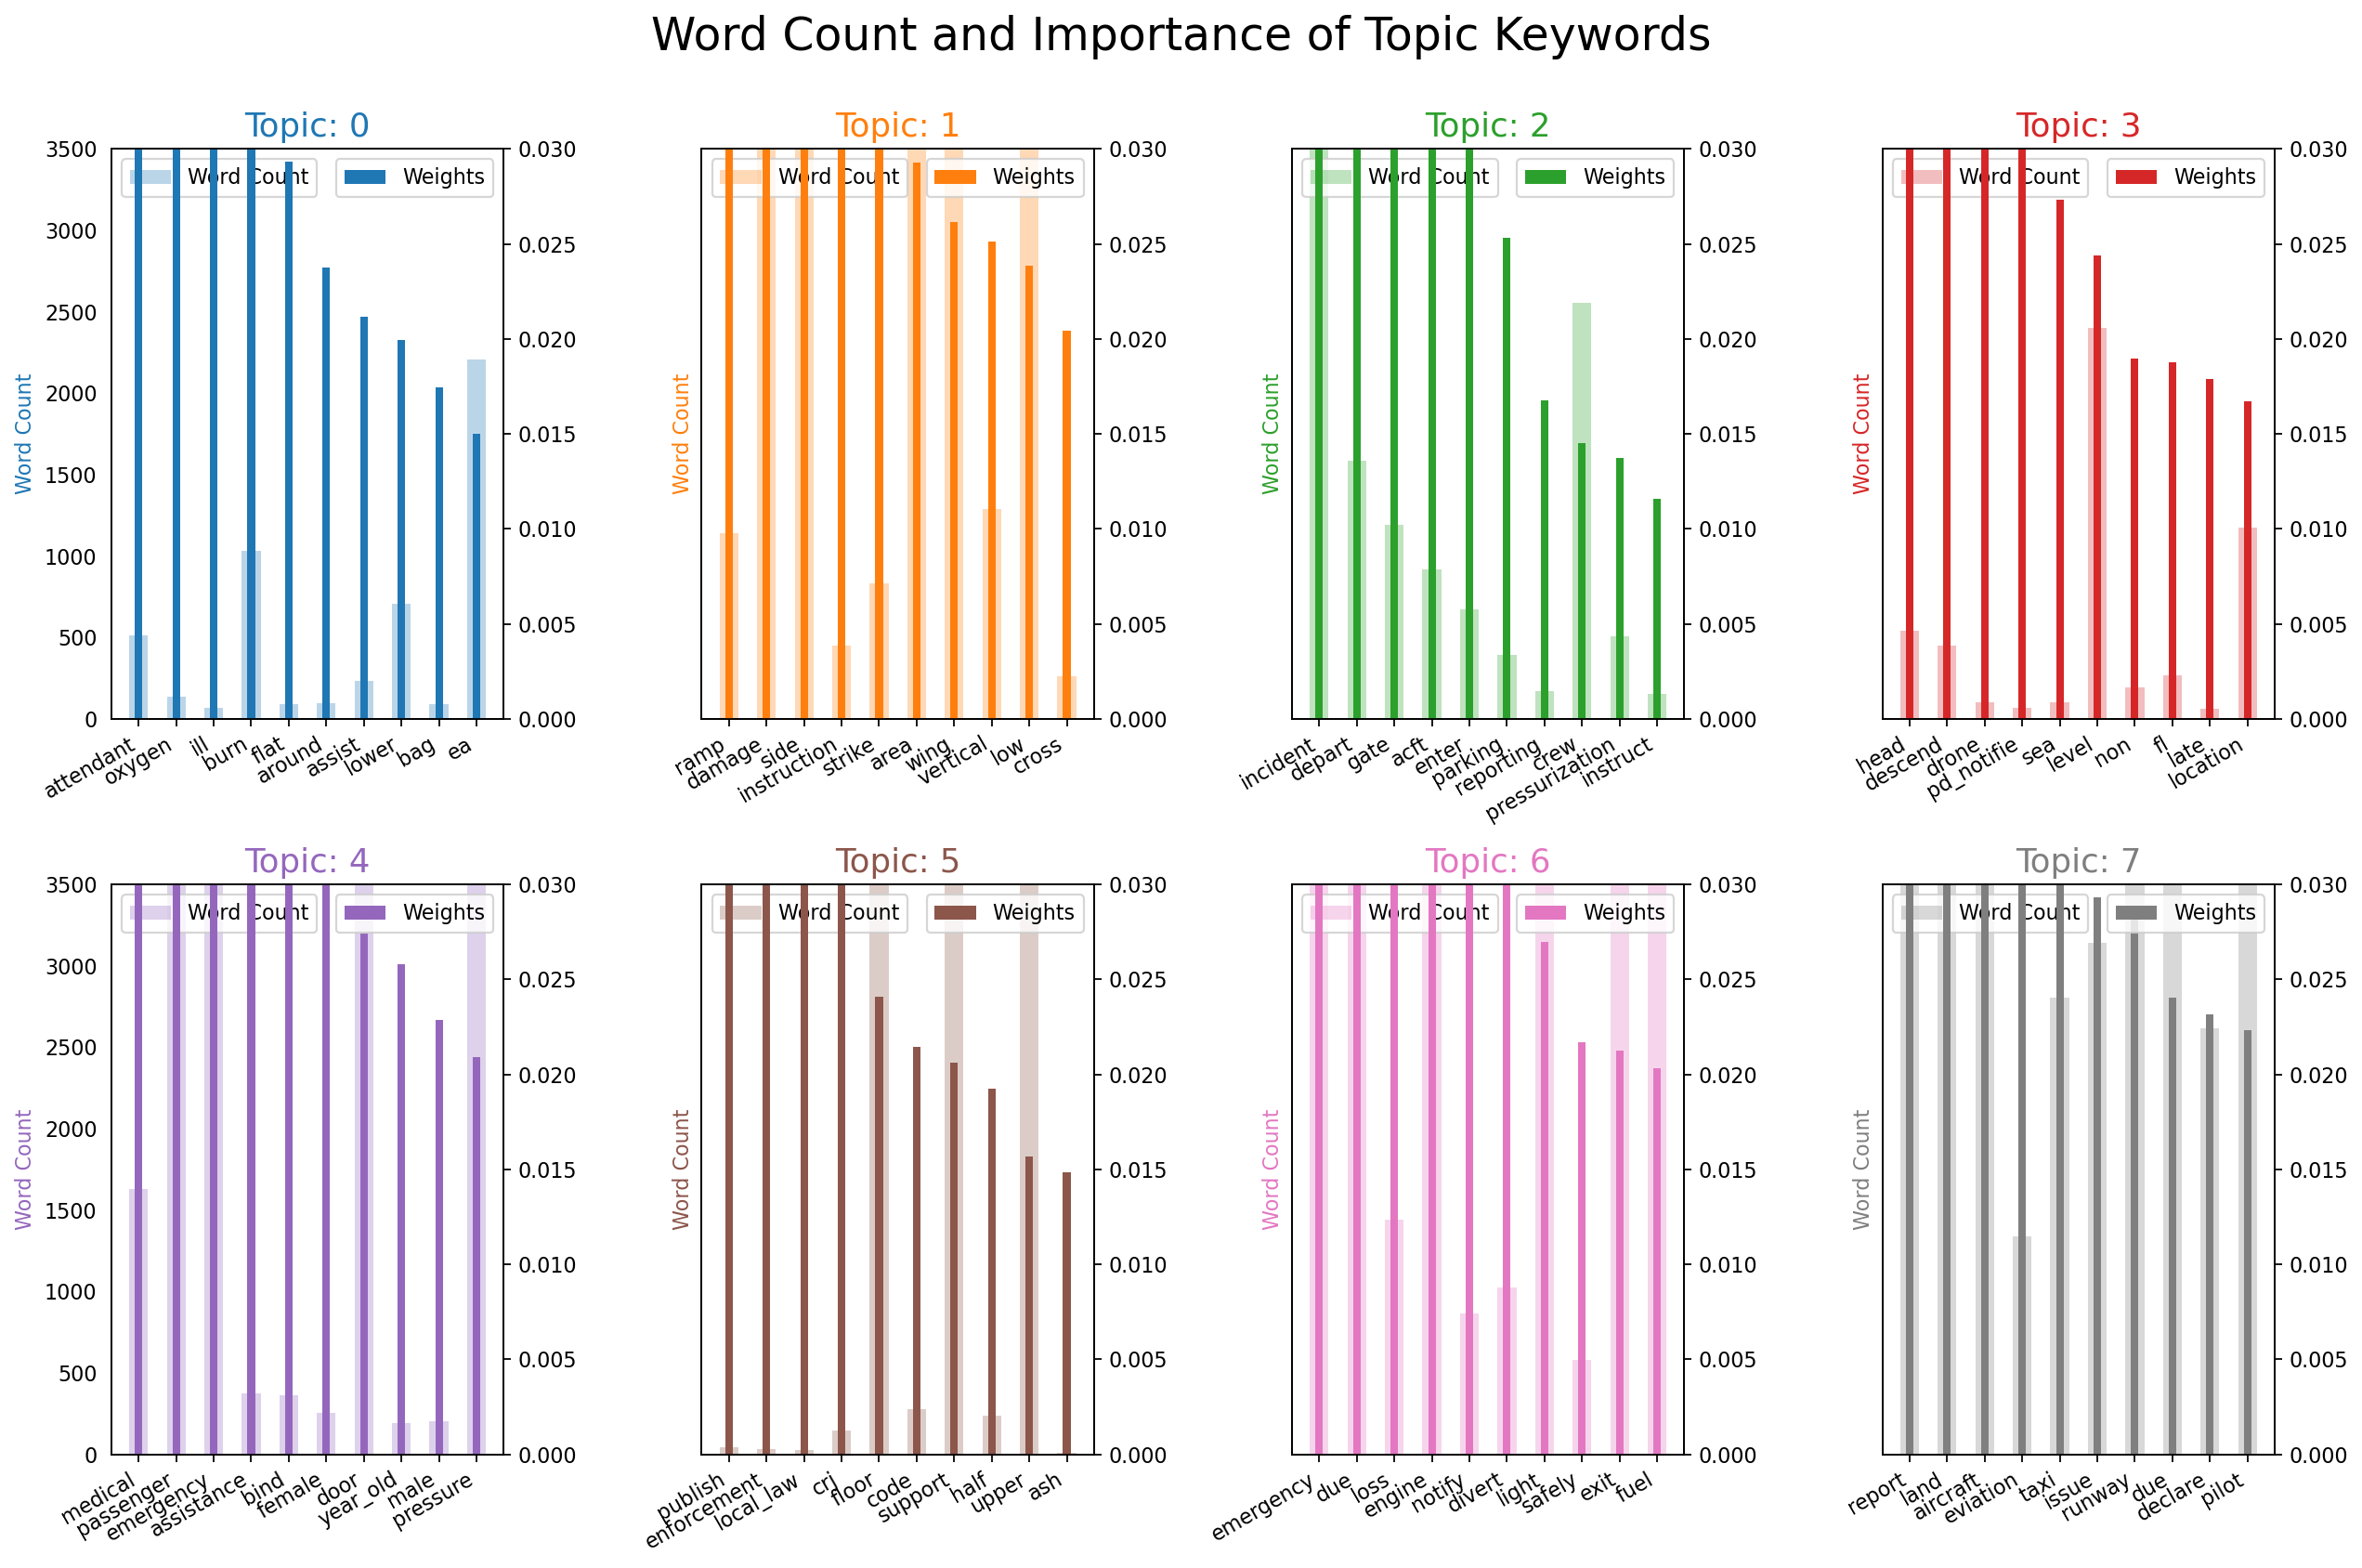

In [43]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### What are the most discussed topics in the documents?
#### Let’s compute the total number of documents attributed to each topic.

In [44]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

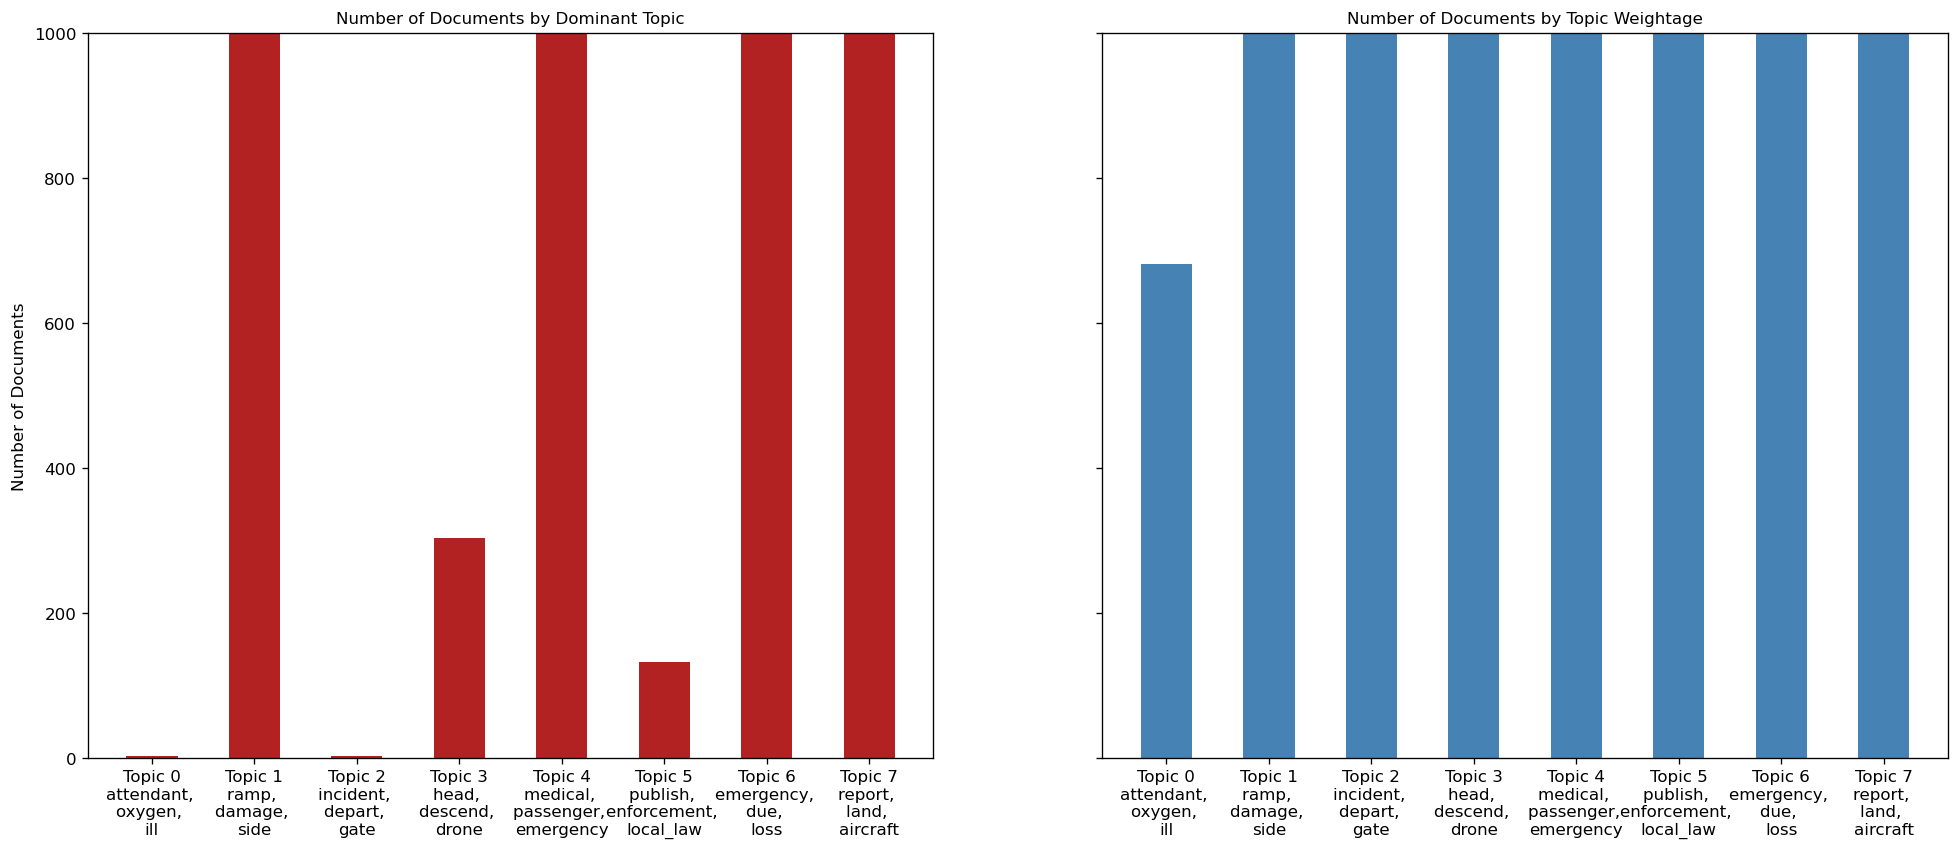

In [45]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [46]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 63056 samples in 0.169s...
[t-SNE] Computed neighbors for 63056 samples in 3.289s...
[t-SNE] Computed conditional probabilities for sample 1000 / 63056
[t-SNE] Computed conditional probabilities for sample 2000 / 63056
[t-SNE] Computed conditional probabilities for sample 3000 / 63056
[t-SNE] Computed conditional probabilities for sample 4000 / 63056
[t-SNE] Computed conditional probabilities for sample 5000 / 63056
[t-SNE] Computed conditional probabilities for sample 6000 / 63056
[t-SNE] Computed conditional probabilities for sample 7000 / 63056
[t-SNE] Computed conditional probabilities for sample 8000 / 63056
[t-SNE] Computed conditional probabilities for sample 9000 / 63056
[t-SNE] Computed conditional probabilities for sample 10000 / 63056
[t-SNE] Computed conditional probabilities for sample 11000 / 63056
[t-SNE] Computed conditional probabilities for sample 12000 / 63056
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [47]:
##############################

In [48]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

Dominant_Topic  \
0.0                 6.0   
1.0                 6.0   
2.0                 6.0   
3.0                 6.0   
4.0                 6.0   
...                 ...   
73135.0             3.0   
73136.0             3.0   
73137.0             3.0   
73138.0             3.0   
73139.0             3.0   

                                                                             Topic_Keywords  \
0.0      aircraft, pilot, gear, landing, runway, flight, leave, damage, nose, approximately   
1.0      aircraft, pilot, gear, landing, runway, flight, leave, damage, nose, approximately   
2.0      aircraft, pilot, gear, landing, runway, flight, leave, damage, nose, approximately   
3.0      aircraft, pilot, gear, landing, runway, flight, leave, damage, nose, approximately   
4.0      aircraft, pilot, gear, landing, runway, flight, leave, damage, nose, approximately   
...                                                                                     ...   
73135.0       aircraft, report, land, due, incident, flight, passenger, return, issue, taxi   
73136.0       aircraft, report, land, due, incident, flight, passenger, return, issue, taxi   
73137.0       aircraft, report, land, due, incident, flight, passenger, return, issue, taxi   
73138.0       aircraft, report, land, due, incident, flight, passenger, return, issue, taxi   
73139.0       aircraft, report, land, due, incident, flight, passenger, return, issue, taxi   

         Num_Documents  Perc_Documents  
0.0            10846.0          0.1483  
1.0            12229.0          0.1672  
2.0             6785.0          0.0928  
3.0             9815.0          0.1342  
4.0             9685.0          0.1324  
...                ...             ...  
73135.0            NaN             NaN  
73136.0            NaN             NaN  
73137.0            NaN             NaN  
73138.0            NaN             NaN  
73139.0            NaN             NaN  

[73140 rows x 4 columns]

In [49]:
import pandas as pd
last =pd.read_csv (" last.csv", low_memory=False)

In [50]:
#last['Dominant_Topic'].astype(str)

In [51]:
grouped_multiple = last.groupby(['Dominant_Topic'])
for key,item in grouped_multiple:
    a_group = grouped_multiple.get_group(key)
print(a_group, "\n")


       Document_No  Dominant_Topic  Topic_Perc_Contrib  \
2452          2452             7.0              0.1614   
2464          2464             7.0              0.2210   
2468          2468             7.0              0.1974   
2470          2470             7.0              0.2073   
2473          2473             7.0              0.2119   
...            ...             ...                 ...   
70182        70182             7.0              0.1572   
71107        71107             7.0              0.1452   
72084        72084             7.0              0.1581   
72154        72154             7.0              0.1572   
72917        72917             7.0              0.1515   

                                                                                 Keywords  \
2452   emergency, light, door, maintenance, replace, exit, service, battery, ground, inop   
2464   emergency, light, door, maintenance, replace, exit, service, battery, ground, inop   
2468   emergency, light,

In [52]:
#Dp=  {0: 'Landing Issue',1: 'Accessible Area Damage',2: 'Maintenance Issue',3: 'Aircraft general Issue',4: 'Wings Damaged',5: 'Flight issue',6: 'Engine related issues',7: 'Emergency cases'}

In [53]:
#last['Dominant_Topic'].replace([0,1,2,3,4,5,6,7],['Wing And Hinge Damage','Landing Issue','Emergency Maintenace','Aircraft Mainteneance and Medical Issue','Pressure and fitting issue','Gear and fuel issue','Corrosion and damage issue','Engine Issues'],inplace=True)

In [54]:
last

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0                0             3.0              0.5473   
1                1             3.0              0.3811   
2                2             3.0              0.4093   
3                3             3.0              0.3864   
4                4             3.0              0.3872   
...            ...             ...                 ...   
73135        73135             0.0              0.2065   
73136        73136             0.0              0.1993   
73137        73137             0.0              0.1798   
73138        73138             0.0              0.1922   
73139        73139             0.0              0.1522   

                                                                                 Keywords  \
0      aircraft, pilot, flight, runway, leave, damage, landing, time, approximately, foot   
1      aircraft, pilot, flight, runway, leave, damage, landing, time, approximately, foot   
2      aircraft, pilot, flight, runway, leave, damage, landing, time, approximately, foot   
3      aircraft, pilot, flight, runway, leave, damage, landing, time, approximately, foot   
4      aircraft, pilot, flight, runway, leave, damage, landing, time, approximately, foot   
...                                                                                   ...   
73135         report, aircraft, land, gear, due, incident, passenger, return, taxi, issue   
73136         report, aircraft, land, gear, due, incident, passenger, return, taxi, issue   
73137         report, aircraft, land, gear, due, incident, passenger, return, taxi, issue   
73138         report, aircraft, land, gear, due, incident, passenger, return, taxi, issue   
73139         report, aircraft, land, gear, due, incident, passenger, return, taxi, issue   

                                                                                                      Text  
0      THE PILOT OBTAINED LOCAL AUTOMATED WEATHER REPORT FROM ICT (WICHITA DWIGHT D. EISENHOWER AIRPORT...  
1      DEPARTED TRL FOR FLIGHT TO GLADEWATER. CLIMBED TO 3000 AGL. APPROX. 2 MINS IN ENGINE BEGAN TO SH...  
2      ON NOVEMBER 25, 2019, AT APPROXIMATELY 1130 EASTERN STANDARD TIME, A MOONEY M20J, N3201L, SUSTAI...  
3      THE PILOT/OWNER WAS INTENDING TO MAKE A SHORT FLIGHT FROM OG20 TO 4S9 DUE TO THE SALE OF THE AIR...  
4      A PORTION OF THE PROPELLER SEPARATED FROM AIRCRAFT WHILE AT 5,500 FEET. THE RESULTING VIBRATION ...  
...                                                                                                    ...  
73135  EVIATION REPORTED BY ORF WHEN PAT092, C560, FAILED TO MAINTAIN ITS ASSIGNED ALTITUDE WHICH CAUSE...  
73136  EVIATION REPORTED BY ZMP WHEN N339MK, P28A/G, FAILED TO COMPLY WITH ATC INSTRUCTION / PROCEDURES...  
73137  EVIATION REPORTED BY ZAB WHEN OXF165, P28A, CLIMBED TO 055, WELL ABOVE THE MISSED APPROACH ALTIT...  
73138  EVIATION REPORTED BY SCT WHEN SKW3264, CRJ7, THE PILOT FOLLOWED THE WRONG AIRCRAFT WHILE ON A VI...  
73139                                                                            AIRBUS EC130, LATE REPORT  

[73140 rows x 5 columns]

In [77]:
last.to_csv (r'E:\Studies\SEM 4 SPRING 2021\Dhruvith Python\ last_all.csv', index = False, header=True)

print (last)

       Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0                0             3.0              0.5473   
1                1             3.0              0.3811   
2                2             3.0              0.4093   
3                3             3.0              0.3864   
4                4             3.0              0.3872   
...            ...             ...                 ...   
73135        73135             0.0              0.2065   
73136        73136             0.0              0.1993   
73137        73137             0.0              0.1798   
73138        73138             0.0              0.1922   
73139        73139             0.0              0.1522   

                                                                                 Keywords  \
0      aircraft, pilot, flight, runway, leave, damage, landing, time, approximately, foot   
1      aircraft, pilot, flight, runway, leave, damage, landing, time, approximately, foot   
2      aircraft, pilot, 

In [78]:

final['Dominant_Topic'] = last['Dominant_Topic'].values

In [79]:

#final['Text'] = last['Text'].values

In [80]:
final

Report_Type Unique Identifier Date_Of_Occurrence    Aircraft_Type  \
0             AID   20191013023229A         2019-10-13    TAYLOR BC12-D   
1             AID   20191122023189A         2019-11-22     CIRRUS SR22T   
2             AID   20191125023199I         2019-11-25      MOONEY M20J   
3             AID   20191217023209A         2019-12-17        BEECH 35R   
4             AID   20191218023219I         2019-12-18  PIPER PA-28-151   
...           ...               ...                ...              ...   
73135         EON            570860         2019-03-19             C560   
73136         EON            570863         2019-03-29           P28A/G   
73137         EON            570944         2019-03-29             P28A   
73138         EON            570947         2019-03-29             CRJ7   
73139         EON            574105         2019-03-31     AIRBUS EC130   

      N_Number  \
0        96709   
1        969JM   
2        3201L   
3        3113V   
4        6919J   
...        ...   
73135   PAT092   
73136    339MK   
73137   OXF165   
73138  SKW3264   
73139   C-GTNV   

                                                                                                   Remarks  \
0      THE PILOT OBTAINED LOCAL AUTOMATED WEATHER REPORT FROM ICT (WICHITA DWIGHT D. EISENHOWER AIRPORT...   
1      DEPARTED TRL FOR FLIGHT TO GLADEWATER. CLIMBED TO 3000' AGL. APPROX. 2 MINS IN ENGINE BEGAN TO S...   
2      ON NOVEMBER 25, 2019, AT APPROXIMATELY 1130 EASTERN STANDARD TIME, A MOONEY M20J, N3201L, SUSTAI...   
3      THE PILOT/OWNER WAS INTENDING TO MAKE A SHORT FLIGHT FROM OG20 TO 4S9 DUE TO THE SALE OF THE AIR...   
4      A PORTION OF THE PROPELLER SEPARATED FROM AIRCRAFT WHILE AT 5,500 FEET. THE RESULTING VIBRATION ...   
...                                                                                                    ...   
73135  EVIATION REPORTED BY ORF WHEN PAT092, C560, FAILED TO MAINTAIN ITS ASSIGNED ALTITUDE WHICH CAUSE...   
73136  EVIATION REPORTED BY ZMP WHEN N339MK, P28A/G, FAILED TO COMPLY WITH ATC INSTRUCTION / PROCEDURES...   
73137  EVIATION REPORTED BY ZAB WHEN OXF165, P28A, CLIMBED TO 055, WELL ABOVE THE MISSED APPROACH ALTIT...   
73138  EVIATION REPORTED BY SCT WHEN SKW3264, CRJ7, THE PILOT FOLLOWED THE WRONG AIRCRAFT WHILE ON A VI...   
73139                                                                            AIRBUS EC130, LATE REPORT   

       Dominant_Topic  
0                 3.0  
1                 3.0  
2                 3.0  
3                 3.0  
4                 3.0  
...               ...  
73135             0.0  
73136             0.0  
73137             0.0  
73138             0.0  
73139             0.0  

[73140 rows x 7 columns]

In [81]:
final.dtypes

Report_Type            object
Unique Identifier      object
Date_Of_Occurrence     object
Aircraft_Type          object
N_Number               object
Remarks                object
Dominant_Topic        float64
dtype: object

In [82]:
final["Dominant_Topic"]

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
73135    0.0
73136    0.0
73137    0.0
73138    0.0
73139    0.0
Name: Dominant_Topic, Length: 73140, dtype: float64

In [83]:
final["Remarks"]

0        THE PILOT OBTAINED LOCAL AUTOMATED WEATHER REPORT FROM ICT (WICHITA DWIGHT D. EISENHOWER AIRPORT...
1        DEPARTED TRL FOR FLIGHT TO GLADEWATER. CLIMBED TO 3000' AGL. APPROX. 2 MINS IN ENGINE BEGAN TO S...
2        ON NOVEMBER 25, 2019, AT APPROXIMATELY 1130 EASTERN STANDARD TIME, A MOONEY M20J, N3201L, SUSTAI...
3        THE PILOT/OWNER WAS INTENDING TO MAKE A SHORT FLIGHT FROM OG20 TO 4S9 DUE TO THE SALE OF THE AIR...
4        A PORTION OF THE PROPELLER SEPARATED FROM AIRCRAFT WHILE AT 5,500 FEET. THE RESULTING VIBRATION ...
                                                        ...                                                 
73135    EVIATION REPORTED BY ORF WHEN PAT092, C560, FAILED TO MAINTAIN ITS ASSIGNED ALTITUDE WHICH CAUSE...
73136    EVIATION REPORTED BY ZMP WHEN N339MK, P28A/G, FAILED TO COMPLY WITH ATC INSTRUCTION / PROCEDURES...
73137    EVIATION REPORTED BY ZAB WHEN OXF165, P28A, CLIMBED TO 055, WELL ABOVE THE MISSED APPROACH ALTIT...
73138    EVIATION R

In [84]:
#final["Dominant_Topic"]=final["Dominant_Topic"].astype(str)

### DATA CONVERSION TO NUMBERS

In [85]:
#def LabelChange(m):
   # if m == "Wing And Hinge Damage":
      #  return 0
   # elif m== "Landing Issue":
        #return 1
    #elif m== "Emergency Maintenace":
      #  return 2
   # elif m== "Aircraft Mainteneance and Medical Issue":
    #    return 3
   # elif m== "Pressure and fitting issue":
    #    return 4
   # elif m== "Gear and fuel issue":
   #     return 5
   # elif m== "Corrosion and damage issue":
   #     return 6
   # else:
      #  return 7
#
    
    
    
        
#final["Dominant_Topic"] = final["Dominant_Topic"].apply(LabelChange)

In [86]:
final["Dominant_Topic"] = final["Dominant_Topic"].astype(int)

In [87]:
final

Report_Type Unique Identifier Date_Of_Occurrence    Aircraft_Type  \
0             AID   20191013023229A         2019-10-13    TAYLOR BC12-D   
1             AID   20191122023189A         2019-11-22     CIRRUS SR22T   
2             AID   20191125023199I         2019-11-25      MOONEY M20J   
3             AID   20191217023209A         2019-12-17        BEECH 35R   
4             AID   20191218023219I         2019-12-18  PIPER PA-28-151   
...           ...               ...                ...              ...   
73135         EON            570860         2019-03-19             C560   
73136         EON            570863         2019-03-29           P28A/G   
73137         EON            570944         2019-03-29             P28A   
73138         EON            570947         2019-03-29             CRJ7   
73139         EON            574105         2019-03-31     AIRBUS EC130   

      N_Number  \
0        96709   
1        969JM   
2        3201L   
3        3113V   
4        6919J   
...        ...   
73135   PAT092   
73136    339MK   
73137   OXF165   
73138  SKW3264   
73139   C-GTNV   

                                                                                                   Remarks  \
0      THE PILOT OBTAINED LOCAL AUTOMATED WEATHER REPORT FROM ICT (WICHITA DWIGHT D. EISENHOWER AIRPORT...   
1      DEPARTED TRL FOR FLIGHT TO GLADEWATER. CLIMBED TO 3000' AGL. APPROX. 2 MINS IN ENGINE BEGAN TO S...   
2      ON NOVEMBER 25, 2019, AT APPROXIMATELY 1130 EASTERN STANDARD TIME, A MOONEY M20J, N3201L, SUSTAI...   
3      THE PILOT/OWNER WAS INTENDING TO MAKE A SHORT FLIGHT FROM OG20 TO 4S9 DUE TO THE SALE OF THE AIR...   
4      A PORTION OF THE PROPELLER SEPARATED FROM AIRCRAFT WHILE AT 5,500 FEET. THE RESULTING VIBRATION ...   
...                                                                                                    ...   
73135  EVIATION REPORTED BY ORF WHEN PAT092, C560, FAILED TO MAINTAIN ITS ASSIGNED ALTITUDE WHICH CAUSE...   
73136  EVIATION REPORTED BY ZMP WHEN N339MK, P28A/G, FAILED TO COMPLY WITH ATC INSTRUCTION / PROCEDURES...   
73137  EVIATION REPORTED BY ZAB WHEN OXF165, P28A, CLIMBED TO 055, WELL ABOVE THE MISSED APPROACH ALTIT...   
73138  EVIATION REPORTED BY SCT WHEN SKW3264, CRJ7, THE PILOT FOLLOWED THE WRONG AIRCRAFT WHILE ON A VI...   
73139                                                                            AIRBUS EC130, LATE REPORT   

       Dominant_Topic  
0                   3  
1                   3  
2                   3  
3                   3  
4                   3  
...               ...  
73135               0  
73136               0  
73137               0  
73138               0  
73139               0  

[73140 rows x 7 columns]

In [88]:
final.to_csv (r'E:\Studies\SEM 4 SPRING 2021\Dhruvith Python\Final_data.csv', index = False, header=True)

print (final)

      Report_Type Unique Identifier Date_Of_Occurrence    Aircraft_Type  \
0             AID   20191013023229A         2019-10-13    TAYLOR BC12-D   
1             AID   20191122023189A         2019-11-22     CIRRUS SR22T   
2             AID   20191125023199I         2019-11-25      MOONEY M20J   
3             AID   20191217023209A         2019-12-17        BEECH 35R   
4             AID   20191218023219I         2019-12-18  PIPER PA-28-151   
...           ...               ...                ...              ...   
73135         EON            570860         2019-03-19             C560   
73136         EON            570863         2019-03-29           P28A/G   
73137         EON            570944         2019-03-29             P28A   
73138         EON            570947         2019-03-29             CRJ7   
73139         EON            574105         2019-03-31     AIRBUS EC130   

      N_Number  \
0        96709   
1        969JM   
2        3201L   
3        3113V   
4        

In [89]:
grouped_multiple = final.groupby(['Dominant_Topic','Aircraft_Type'])
for key,item in grouped_multiple:
    a_group = grouped_multiple.get_group(key)
print(a_group, "\n")

      Report_Type Unique Identifier Date_Of_Occurrence Aircraft_Type N_Number  \
69120         EON            562361         2019-02-27          TBM9    910GE   

                                                                      Remarks  \
69120  TBM9, BFIABORTED TAKEOFF DUE TO DOOR LIGHT INDICATOR. 02/27/2019 1759Z   

       Dominant_Topic  
69120               7   



In [184]:
final1=final.head(20000)

### TF-IDF VECTORIOZING

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode")
x = vec.fit_transform(final1["Remarks"])
print(x.shape)

(20000, 34404)


In [186]:
x= vec.fit(final1["Remarks"])
print(x.vocabulary_)
print(x.get_feature_names())

{'the': 31799, 'pilot': 26571, 'obtained': 25340, 'local': 22361, 'automated': 12127, 'weather': 33730, 'report': 28251, 'from': 18698, 'ict': 20037, 'wichita': 33854, 'dwight': 16561, 'eisenhower': 16864, 'airport': 11241, 'ks': 21689, 'prior': 27087, 'to': 32043, 'takeoff': 31530, 'indicating': 20357, 'clear': 14032, 'skies': 30043, 'light': 22211, 'variable': 33284, 'winds': 33903, 'and': 11497, 'temperature': 31699, '69f': 8103, 'eck': 16721, 'field': 18081, 'windsock': 33915, 'indicated': 20353, 'at': 11963, '10': 1545, 'mph': 23624, 'out': 25830, 'of': 25410, 'sse': 30576, 'taxied': 31602, 'north': 25098, 'end': 17065, 'runway': 28975, 'with': 33961, 'one': 25550, 'passenger': 26243, 'conducted': 14449, 'normal': 25089, 'run': 28962, 'up': 32910, 'then': 31807, 'advanced': 11021, 'throttle': 31900, 'full': 18788, 'power': 26878, 'for': 18468, 'aircraft': 11205, 'lifted': 22205, 'off': 25418, 'normally': 25092, 'experienced': 17640, 'distance': 16165, 'began': 12532, 'drift': 1642

In [187]:
X = vec.fit_transform(final1["Remarks"]).toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [188]:
df = pd.DataFrame(X,columns=vec.get_feature_names())
y=final1['Dominant_Topic']
df

00  000  0000  00000  00000000  000000001722595  000000001802018  \
0      0.0  0.0   0.0    0.0       0.0              0.0              0.0   
1      0.0  0.0   0.0    0.0       0.0              0.0              0.0   
2      0.0  0.0   0.0    0.0       0.0              0.0              0.0   
3      0.0  0.0   0.0    0.0       0.0              0.0              0.0   
4      0.0  0.0   0.0    0.0       0.0              0.0              0.0   
...    ...  ...   ...    ...       ...              ...              ...   
19995  0.0  0.0   0.0    0.0       0.0              0.0              0.0   
19996  0.0  0.0   0.0    0.0       0.0              0.0              0.0   
19997  0.0  0.0   0.0    0.0       0.0              0.0              0.0   
19998  0.0  0.0   0.0    0.0       0.0              0.0              0.0   
19999  0.0  0.0   0.0    0.0       0.0              0.0              0.0   

       000000001802326  000000001844201  000000001876044  ...  zonearound  \
0                  0.0              0.0              0.0  ...         0.0   
1                  0.0              0.0              0.0  ...         0.0   
2                  0.0              0.0              0.0  ...         0.0   
3                  0.0              0.0              0.0  ...         0.0   
4                  0.0              0.0              0.0  ...         0.0   
...                ...              ...              ...  ...         ...   
19995              0.0              0.0              0.0  ...         0.0   
19996              0.0              0.0              0.0  ...         0.0   
19997              0.0              0.0              0.0  ...         0.0   
19998              0.0              0.0              0.0  ...         0.0   
19999              0.0              0.0              0.0  ...         0.0   

       zones  zonetemp  zontal  zqa  ztc  ztl  zuehl  zulu  zumwalts  
0        0.0       0.0     0.0  0.0  0.0  0.0    0.0   0.0       0.0  
1        0.0       0.0     0.0  0.0  0.0  0.0    0.0   0.0       0.0  
2        0.0       0.0     0.0  0.0  0.0  0.0    0.0   0.0       0.0  
3        0.0       0.0     0.0  0.0  0.0  0.0    0.0   0.0       0.0  
4        0.0       0.0     0.0  0.0  0.0  0.0    0.0   0.0       0.0  
...      ...       ...     ...  ...  ...  ...    ...   ...       ...  
19995    0.0       0.0     0.0  0.0  0.0  0.0    0.0   0.0       0.0  
19996    0.0       0.0     0.0  0.0  0.0  0.0    0.0   0.0       0.0  
19997    0.0       0.0     0.0  0.0  0.0  0.0    0.0   0.0       0.0  
19998    0.0       0.0     0.0  0.0  0.0  0.0    0.0   0.0       0.0  
19999    0.0       0.0     0.0  0.0  0.0  0.0    0.0   0.0       0.0  

[20000 rows x 34404 columns]

### NAIVE BAYES ALGORITHM

In [189]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.30, random_state = 0)
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.naive_bayes import MultinomialNB
smodel = MultinomialNB()
svr=smodel.fit(X_train, y_train)

y_pred=smodel.predict(X_test)

from sklearn.metrics import accuracy_score,fbeta_score,classification_report
print('Accuracy score Naive bayes classifier - TF-IDF vectorizer: {}'.format(accuracy_score(y_test,y_pred)))
#print('Precision score Naive bayes classifier - TF-IDF vectorizer: {}'.format(precision_score(y_test, y_pred)))
#print('Recall score Naive bayes classifier - TF-IDF vectorizer: {}'.format(recall_score(y_test, y_pred)))
#print('F1 score Naive bayes classifier - TF-IDF vectorizer: {}'.format(f1_score(y_test,y_pred)))

Accuracy score Naive bayes classifier - TF-IDF vectorizer: 0.7608333333333334


In [190]:
from sklearn.metrics import mean_squared_error
score = svr.score(X_train,y_train)
print("MSE Naive bayes classifier - TF-IDF vectorizer:", mean_squared_error(y_test, y_pred))

MSE Naive bayes classifier - TF-IDF vectorizer: 2.7693333333333334


In [191]:
print (classification_report(y_test,y_pred))

E:\Softwares\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.87      0.46      0.60       606
           2       0.64      0.86      0.73       973
           3       0.89      0.93      0.91       734
           4       0.84      0.54      0.66       670
           5       0.67      0.96      0.79      1196
           6       0.89      0.48      0.62       637
           7       0.86      0.94      0.90      1004

    accuracy                           0.76      6000
   macro avg       0.71      0.65      0.65      6000
weighted avg       0.77      0.76      0.74      6000



## Cross validation For Naive Bayes with tf-idf vectorizer

In [192]:
from sklearn.model_selection import cross_val_score
nb1 = MultinomialNB()
scores = cross_val_score(nb1, df, y, cv=10, scoring='accuracy')
print(scores.mean())

0.7456499999999999


### RANDOM FOREST

In [193]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.30, random_state = 0)
from sklearn.ensemble import RandomForestClassifier
classifier1=RandomForestClassifier(n_estimators=15,criterion='entropy')
classifier1.fit(X_train,y_train)
predRF=classifier1.predict(X_test)

print('Accuracy score Random Forest Classifier - TF-IDF vectorizer: {}'.format(accuracy_score(y_test,predRF)))

Accuracy score Random Forest Classifier - TF-IDF vectorizer: 0.7906666666666666


In [194]:
from sklearn.metrics import mean_squared_error
score = svr.score(X_train,y_train)
print("MSE Random Forest Classifier - TF-IDF vectorizer:", mean_squared_error(y_test, predRF))

MSE Random Forest Classifier - TF-IDF vectorizer: 2.5375


In [195]:
print (classification_report(y_test,predRF))

              precision    recall  f1-score   support

           0       0.66      0.24      0.36       180
           1       0.80      0.73      0.77       606
           2       0.67      0.86      0.75       973
           3       0.85      0.92      0.89       734
           4       0.77      0.70      0.73       670
           5       0.82      0.90      0.86      1196
           6       0.77      0.47      0.58       637
           7       0.87      0.91      0.89      1004

    accuracy                           0.79      6000
   macro avg       0.78      0.72      0.73      6000
weighted avg       0.79      0.79      0.78      6000



In [196]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [197]:
# get importance
importance = classifier1.feature_importances_

In [203]:
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    #plot feature importance


Feature: 0, Score: 0.00369
Feature: 1, Score: 0.00076
Feature: 2, Score: 0.00001
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00001
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00001
Feature: 22, Score: 0.00001
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00001
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Feature: 2366, Score: 0.00000
Feature: 2367, Score: 0.00000
Feature: 2368, Score: 0.00000
Feature: 2369, Score: 0.00000
Feature: 2370, Score: 0.00000
Feature: 2371, Score: 0.00000
Feature: 2372, Score: 0.00000
Feature: 2373, Score: 0.00000
Feature: 2374, Score: 0.00000
Feature: 2375, Score: 0.00001
Feature: 2376, Score: 0.00000
Feature: 2377, Score: 0.00000
Feature: 2378, Score: 0.00000
Feature: 2379, Score: 0.00001
Feature: 2380, Score: 0.00000
Feature: 2381, Score: 0.00000
Feature: 2382, Score: 0.00000
Feature: 2383, Score: 0.00000
Feature: 2384, Score: 0.00000
Feature: 2385, Score: 0.00000
Feature: 2386, Score: 0.00000
Feature: 2387, Score: 0.00000
Feature: 2388, Score: 0.00000
Feature: 2389, Score: 0.00000
Feature: 2390, Score: 0.00000
Feature: 2391, Score: 0.00000
Feature: 2392, Score: 0.00000
Feature: 2393, Score: 0.00000
Feature: 2394, Score: 0.00000
Feature: 2395, Score: 0.00000
Feature: 2396, Score: 0.00000
Feature: 2397, Score: 0.00000
Feature: 2398, Score: 0.00000
Feature: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Feature: 4809, Score: 0.00003
Feature: 4810, Score: 0.00001
Feature: 4811, Score: 0.00000
Feature: 4812, Score: 0.00000
Feature: 4813, Score: 0.00000
Feature: 4814, Score: 0.00000
Feature: 4815, Score: 0.00000
Feature: 4816, Score: 0.00000
Feature: 4817, Score: 0.00000
Feature: 4818, Score: 0.00000
Feature: 4819, Score: 0.00000
Feature: 4820, Score: 0.00001
Feature: 4821, Score: 0.00001
Feature: 4822, Score: 0.00000
Feature: 4823, Score: 0.00000
Feature: 4824, Score: 0.00000
Feature: 4825, Score: 0.00000
Feature: 4826, Score: 0.00000
Feature: 4827, Score: 0.00000
Feature: 4828, Score: 0.00000
Feature: 4829, Score: 0.00001
Feature: 4830, Score: 0.00000
Feature: 4831, Score: 0.00000
Feature: 4832, Score: 0.00000
Feature: 4833, Score: 0.00000
Feature: 4834, Score: 0.00003
Feature: 4835, Score: 0.00000
Feature: 4836, Score: 0.00000
Feature: 4837, Score: 0.00000
Feature: 4838, Score: 0.00005
Feature: 4839, Score: 0.00000
Feature: 4840, Score: 0.00000
Feature: 4841, Score: 0.00000
Feature: 4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Feature: 7193, Score: 0.00000
Feature: 7194, Score: 0.00000
Feature: 7195, Score: 0.00000
Feature: 7196, Score: 0.00002
Feature: 7197, Score: 0.00000
Feature: 7198, Score: 0.00000
Feature: 7199, Score: 0.00000
Feature: 7200, Score: 0.00002
Feature: 7201, Score: 0.00023
Feature: 7202, Score: 0.00000
Feature: 7203, Score: 0.00000
Feature: 7204, Score: 0.00000
Feature: 7205, Score: 0.00000
Feature: 7206, Score: 0.00002
Feature: 7207, Score: 0.00000
Feature: 7208, Score: 0.00002
Feature: 7209, Score: 0.00000
Feature: 7210, Score: 0.00000
Feature: 7211, Score: 0.00000
Feature: 7212, Score: 0.00000
Feature: 7213, Score: 0.00000
Feature: 7214, Score: 0.00000
Feature: 7215, Score: 0.00000
Feature: 7216, Score: 0.00000
Feature: 7217, Score: 0.00000
Feature: 7218, Score: 0.00000
Feature: 7219, Score: 0.00001
Feature: 7220, Score: 0.00000
Feature: 7221, Score: 0.00000
Feature: 7222, Score: 0.00000
Feature: 7223, Score: 0.00000
Feature: 7224, Score: 0.00000
Feature: 7225, Score: 0.00000
Feature: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Feature: 9450, Score: 0.00000
Feature: 9451, Score: 0.00000
Feature: 9452, Score: 0.00000
Feature: 9453, Score: 0.00000
Feature: 9454, Score: 0.00000
Feature: 9455, Score: 0.00000
Feature: 9456, Score: 0.00000
Feature: 9457, Score: 0.00000
Feature: 9458, Score: 0.00000
Feature: 9459, Score: 0.00000
Feature: 9460, Score: 0.00000
Feature: 9461, Score: 0.00000
Feature: 9462, Score: 0.00000
Feature: 9463, Score: 0.00000
Feature: 9464, Score: 0.00000
Feature: 9465, Score: 0.00000
Feature: 9466, Score: 0.00000
Feature: 9467, Score: 0.00000
Feature: 9468, Score: 0.00000
Feature: 9469, Score: 0.00000
Feature: 9470, Score: 0.00000
Feature: 9471, Score: 0.00000
Feature: 9472, Score: 0.00000
Feature: 9473, Score: 0.00000
Feature: 9474, Score: 0.00001
Feature: 9475, Score: 0.00000
Feature: 9476, Score: 0.00001
Feature: 9477, Score: 0.00000
Feature: 9478, Score: 0.00000
Feature: 9479, Score: 0.00000
Feature: 9480, Score: 0.00000
Feature: 9481, Score: 0.00000
Feature: 9482, Score: 0.00000
Feature: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Feature: 11784, Score: 0.00000
Feature: 11785, Score: 0.00000
Feature: 11786, Score: 0.00000
Feature: 11787, Score: 0.00000
Feature: 11788, Score: 0.00000
Feature: 11789, Score: 0.00000
Feature: 11790, Score: 0.00000
Feature: 11791, Score: 0.00000
Feature: 11792, Score: 0.00000
Feature: 11793, Score: 0.00000
Feature: 11794, Score: 0.00000
Feature: 11795, Score: 0.00000
Feature: 11796, Score: 0.00000
Feature: 11797, Score: 0.00000
Feature: 11798, Score: 0.00001
Feature: 11799, Score: 0.00000
Feature: 11800, Score: 0.00000
Feature: 11801, Score: 0.00008
Feature: 11802, Score: 0.00000
Feature: 11803, Score: 0.00000
Feature: 11804, Score: 0.00003
Feature: 11805, Score: 0.00000
Feature: 11806, Score: 0.00000
Feature: 11807, Score: 0.00000
Feature: 11808, Score: 0.00000
Feature: 11809, Score: 0.00000
Feature: 11810, Score: 0.00000
Feature: 11811, Score: 0.00000
Feature: 11812, Score: 0.00003
Feature: 11813, Score: 0.00000
Feature: 11814, Score: 0.00000
Feature: 11815, Score: 0.00000
Feature:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Feature: 14075, Score: 0.00000
Feature: 14076, Score: 0.00035
Feature: 14077, Score: 0.00003
Feature: 14078, Score: 0.00000
Feature: 14079, Score: 0.00005
Feature: 14080, Score: 0.00000
Feature: 14081, Score: 0.00000
Feature: 14082, Score: 0.00000
Feature: 14083, Score: 0.00000
Feature: 14084, Score: 0.00000
Feature: 14085, Score: 0.00012
Feature: 14086, Score: 0.00000
Feature: 14087, Score: 0.00002
Feature: 14088, Score: 0.00000
Feature: 14089, Score: 0.00003
Feature: 14090, Score: 0.00000
Feature: 14091, Score: 0.00003
Feature: 14092, Score: 0.00000
Feature: 14093, Score: 0.00012
Feature: 14094, Score: 0.00040
Feature: 14095, Score: 0.00000
Feature: 14096, Score: 0.00001
Feature: 14097, Score: 0.00001
Feature: 14098, Score: 0.00000
Feature: 14099, Score: 0.00000
Feature: 14100, Score: 0.00002
Feature: 14101, Score: 0.00003
Feature: 14102, Score: 0.00000
Feature: 14103, Score: 0.00000
Feature: 14104, Score: 0.00000
Feature: 14105, Score: 0.00000
Feature: 14106, Score: 0.00000
Feature:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Feature: 15998, Score: 0.00000
Feature: 15999, Score: 0.00001
Feature: 16000, Score: 0.00000
Feature: 16001, Score: 0.00003
Feature: 16002, Score: 0.00000
Feature: 16003, Score: 0.00001
Feature: 16004, Score: 0.00000
Feature: 16005, Score: 0.00001
Feature: 16006, Score: 0.00006
Feature: 16007, Score: 0.00000
Feature: 16008, Score: 0.00001
Feature: 16009, Score: 0.00001
Feature: 16010, Score: 0.00000
Feature: 16011, Score: 0.00000
Feature: 16012, Score: 0.00000
Feature: 16013, Score: 0.00000
Feature: 16014, Score: 0.00018
Feature: 16015, Score: 0.00000
Feature: 16016, Score: 0.00001
Feature: 16017, Score: 0.00000
Feature: 16018, Score: 0.00000
Feature: 16019, Score: 0.00001
Feature: 16020, Score: 0.00000
Feature: 16021, Score: 0.00000
Feature: 16022, Score: 0.00000
Feature: 16023, Score: 0.00004
Feature: 16024, Score: 0.00000
Feature: 16025, Score: 0.00000
Feature: 16026, Score: 0.00000
Feature: 16027, Score: 0.00002
Feature: 16028, Score: 0.00002
Feature: 16029, Score: 0.00000
Feature

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Feature: 19424, Score: 0.00000
Feature: 19425, Score: 0.00000
Feature: 19426, Score: 0.00000
Feature: 19427, Score: 0.00000
Feature: 19428, Score: 0.00000
Feature: 19429, Score: 0.00000
Feature: 19430, Score: 0.00000
Feature: 19431, Score: 0.00000
Feature: 19432, Score: 0.00000
Feature: 19433, Score: 0.00000
Feature: 19434, Score: 0.00001
Feature: 19435, Score: 0.00127
Feature: 19436, Score: 0.00000
Feature: 19437, Score: 0.00000
Feature: 19438, Score: 0.00000
Feature: 19439, Score: 0.00002
Feature: 19440, Score: 0.00000
Feature: 19441, Score: 0.00000
Feature: 19442, Score: 0.00000
Feature: 19443, Score: 0.00031
Feature: 19444, Score: 0.00000
Feature: 19445, Score: 0.00000
Feature: 19446, Score: 0.00000
Feature: 19447, Score: 0.00002
Feature: 19448, Score: 0.00000
Feature: 19449, Score: 0.00000
Feature: 19450, Score: 0.00000
Feature: 19451, Score: 0.00000
Feature: 19452, Score: 0.00000
Feature: 19453, Score: 0.00000
Feature: 19454, Score: 0.00012
Feature: 19455, Score: 0.00000
Feature:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Feature: 24235, Score: 0.00000
Feature: 24236, Score: 0.00000
Feature: 24237, Score: 0.00000
Feature: 24238, Score: 0.00000
Feature: 24239, Score: 0.00000
Feature: 24240, Score: 0.00000
Feature: 24241, Score: 0.00000
Feature: 24242, Score: 0.00000
Feature: 24243, Score: 0.00000
Feature: 24244, Score: 0.00000
Feature: 24245, Score: 0.00000
Feature: 24246, Score: 0.00000
Feature: 24247, Score: 0.00000
Feature: 24248, Score: 0.00000
Feature: 24249, Score: 0.00000
Feature: 24250, Score: 0.00000
Feature: 24251, Score: 0.00000
Feature: 24252, Score: 0.00000
Feature: 24253, Score: 0.00000
Feature: 24254, Score: 0.00000
Feature: 24255, Score: 0.00000
Feature: 24256, Score: 0.00000
Feature: 24257, Score: 0.00000
Feature: 24258, Score: 0.00000
Feature: 24259, Score: 0.00000
Feature: 24260, Score: 0.00000
Feature: 24261, Score: 0.00000
Feature: 24262, Score: 0.00000
Feature: 24263, Score: 0.00000
Feature: 24264, Score: 0.00000
Feature: 24265, Score: 0.00000
Feature: 24266, Score: 0.00000
Feature:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Feature: 29055, Score: 0.00000
Feature: 29056, Score: 0.00000
Feature: 29057, Score: 0.00000
Feature: 29058, Score: 0.00000
Feature: 29059, Score: 0.00000
Feature: 29060, Score: 0.00000
Feature: 29061, Score: 0.00000
Feature: 29062, Score: 0.00000
Feature: 29063, Score: 0.00000
Feature: 29064, Score: 0.00001
Feature: 29065, Score: 0.00001
Feature: 29066, Score: 0.00000
Feature: 29067, Score: 0.00002
Feature: 29068, Score: 0.00001
Feature: 29069, Score: 0.00000
Feature: 29070, Score: 0.00000
Feature: 29071, Score: 0.00004
Feature: 29072, Score: 0.00000
Feature: 29073, Score: 0.00000
Feature: 29074, Score: 0.00000
Feature: 29075, Score: 0.00000
Feature: 29076, Score: 0.00001
Feature: 29077, Score: 0.00000
Feature: 29078, Score: 0.00000
Feature: 29079, Score: 0.00000
Feature: 29080, Score: 0.00000
Feature: 29081, Score: 0.00001
Feature: 29082, Score: 0.00000
Feature: 29083, Score: 0.00000
Feature: 29084, Score: 0.00002
Feature: 29085, Score: 0.00000
Feature: 29086, Score: 0.00000
Feature

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Feature: 33428, Score: 0.00000
Feature: 33429, Score: 0.00000
Feature: 33430, Score: 0.00000
Feature: 33431, Score: 0.00000
Feature: 33432, Score: 0.00000
Feature: 33433, Score: 0.00000
Feature: 33434, Score: 0.00001
Feature: 33435, Score: 0.00000
Feature: 33436, Score: 0.00020
Feature: 33437, Score: 0.00001
Feature: 33438, Score: 0.00000
Feature: 33439, Score: 0.00000
Feature: 33440, Score: 0.00000
Feature: 33441, Score: 0.00000
Feature: 33442, Score: 0.00000
Feature: 33443, Score: 0.00000
Feature: 33444, Score: 0.00000
Feature: 33445, Score: 0.00000
Feature: 33446, Score: 0.00000
Feature: 33447, Score: 0.00000
Feature: 33448, Score: 0.00000
Feature: 33449, Score: 0.00000
Feature: 33450, Score: 0.00000
Feature: 33451, Score: 0.00000
Feature: 33452, Score: 0.00000
Feature: 33453, Score: 0.00000
Feature: 33454, Score: 0.00000
Feature: 33455, Score: 0.00000
Feature: 33456, Score: 0.00000
Feature: 33457, Score: 0.00000
Feature: 33458, Score: 0.00000
Feature: 33459, Score: 0.00000
Feature:

### Checking Results

In [199]:
Text = ["bolt has been damaged"]

In [200]:
examples = vec.transform(Text)
predictions = classifier1.predict(examples)
predictions

array([4])